In [1]:
import os
import sys; sys.path.insert(0, os.path.abspath("../"))
import cv2
import numpy as np 
import matplotlib.pyplot as plt
from utils.plots import get_image, get_image_and_plot
from tqdm import tqdm

In [37]:

def hair_removal(paths_list):
    # red channel used. after mask creation, opening + dilation is applied to extend the mask.
    for i in paths_list:
        # image= get_image(image_num, path)
        image = cv2.imread(i, cv2.IMREAD_COLOR)
        # red_channel
        red = image[:,:,2]
        # Black hat filter
        kernel = cv2.getStructuringElement(1,(20,20))
        blackhat = cv2.morphologyEx(red, cv2.MORPH_BLACKHAT, kernel)
        # Gaussian filter
        bhg= cv2.GaussianBlur(blackhat,(3,3),cv2.BORDER_DEFAULT)
        #Binary thresholding (MASK)
        ret,mask = cv2.threshold(bhg,10,255,cv2.THRESH_BINARY)

        # apply opening : erosion+dilation (remove the dots that are captured and then extend the hair parts)
        kernel_opening = np.ones((1, 1), np.uint8)
        opening = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel_opening)
        kernel_dilation = np.ones((5, 5), np.uint8)
        dilated_mask = cv2.dilate(opening, kernel_dilation, iterations=1)

        #Replace pixels of the mask
        return cv2.inpaint(image,dilated_mask,6,cv2.INPAINT_TELEA)

def crop_img(img, threshold=100):
    '''
    Crop the image to get the region of interest. Remove the vignette frame.
    Analyze the value of the pixels in the diagonal of the image, from 0,0 to h,w and
    take the points where this value crosses the threshold by the first time and for last.
    Args:
    - img (numpy ndarray): Image to crop.
    - threshold (int): Value to split the diagonal into image and frame.
    Return:
    - The coordinates of the rectangle and the cropped image.
    '''
    # Get the image dimensions
    h, w = img.shape[:2]

    # Get the coordinates of the pixels in the diagonal
    y_coords = ([i for i in range(0, h, 3)], [i for i in range(h - 3, -1, -3)])
    x_coords = ([i for i in range(0, w, 4)], [i for i in range(0, w, 4)])

    # Get the mean value of the pixels in the diagonal, form 0,0 to h,w 
    # and from h,0 to 0,w
    coordinates = {'y1_1': 0, 'x1_1': 0, 'y2_1': h, 'x2_1': w, 'y1_2': h, 'x1_2': 0, 'y2_2': 0, 'x2_2': w}
    for i in range(2):
        d = []
        y1_aux, x1_aux = 0, 0
        y2_aux, x2_aux = h, w 
        for y, x in zip(y_coords[i], x_coords[i]):
            d.append(np.mean(img[y, x, :]))

        # Get the location of the first point where the threshold is crossed
        for idx, value in enumerate(d):
            if value >= threshold:
                coordinates['y1_' + str(i + 1)] = y_coords[i][idx]
                coordinates['x1_' + str(i + 1)] = x_coords[i][idx]
                break

        # Get the location of the last point where the threshold is crossed
        for idx, value in enumerate(reversed(d)):
            if value >= threshold:
                coordinates['y2_' + str(i + 1)] = y_coords[i][-idx if idx != 0 else -1]
                coordinates['x2_' + str(i + 1)] = x_coords[i][-idx if idx != 0 else -1]
                break

    # Set the coordinates to crop the image

    # modified
    # y1 = min(coordinates['y1_1'], coordinates['y1_2'])
    # y2 = max(coordinates['y2_1'], coordinates['y2_2'])

    # original
    y1 = max(coordinates['y1_1'], coordinates['y2_2'])
    y2 = min(coordinates['y2_1'], coordinates['y1_2'])

    # original
    # x1 = max(coordinates['x1_1'], coordinates['x1_2'])
    # x2 = min(coordinates['x2_1'], coordinates['x2_2'])

    # modified
    x1 = max(coordinates['x1_1'], coordinates['x2_2'])
    x2 = min(coordinates['x2_1'], coordinates['x1_2'])
    
    return img[y1:y2, x1:x2, :], y1, y2, x1, x2

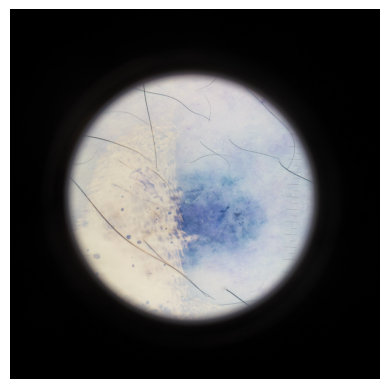

In [4]:
path = '../data/binary/train/nevus/'
img_list_num = ["00002", "00010", "00009", "00013", "00061", "00072",
                "00171", "00208", "00246", "00286", "00348", "00380"]
image = get_image_and_plot(img_list_num[0], path)

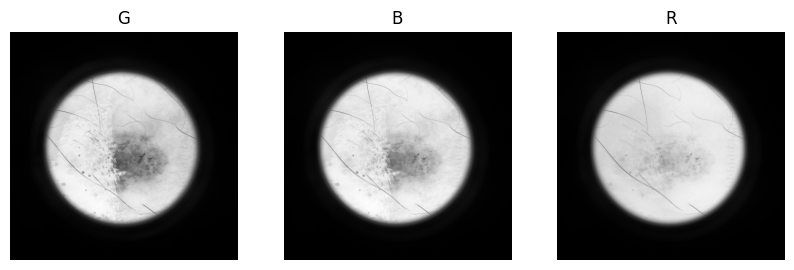

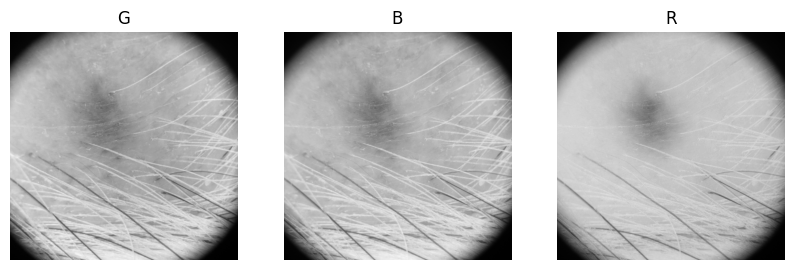

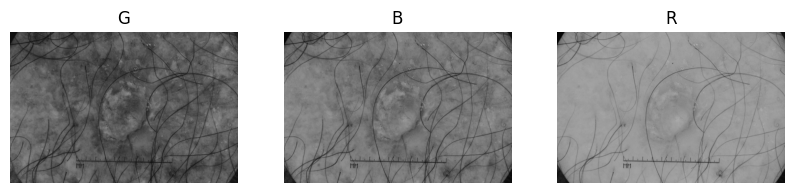

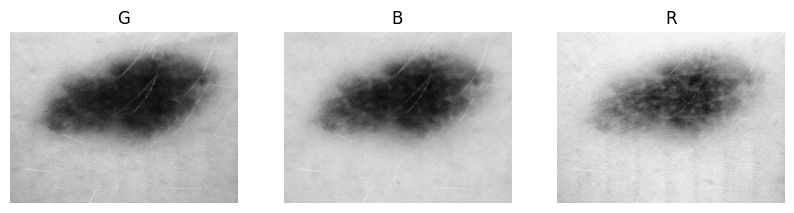

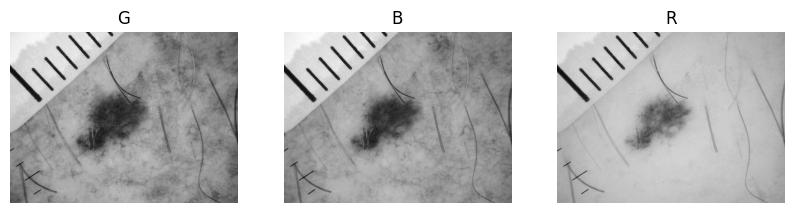

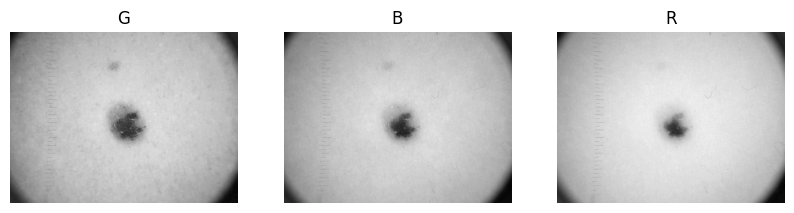

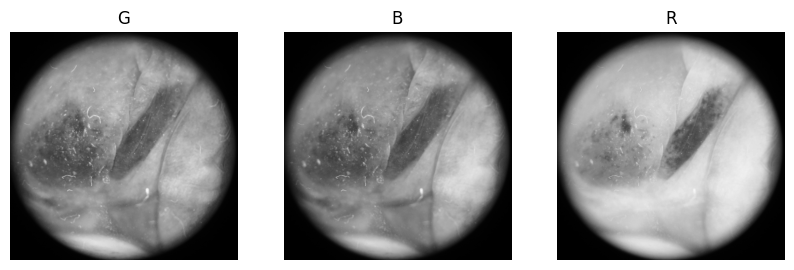

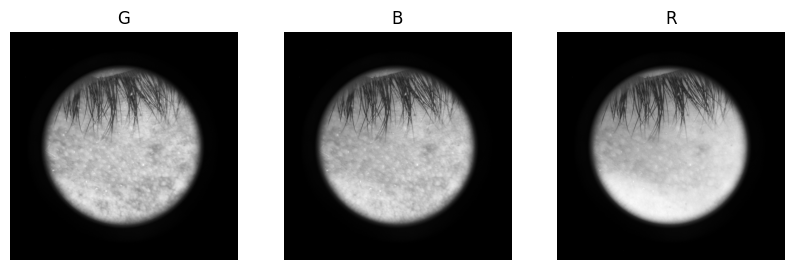

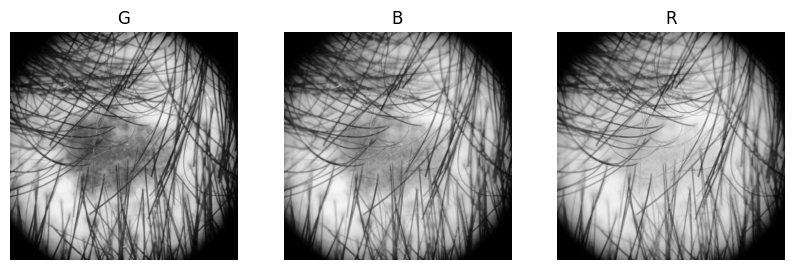

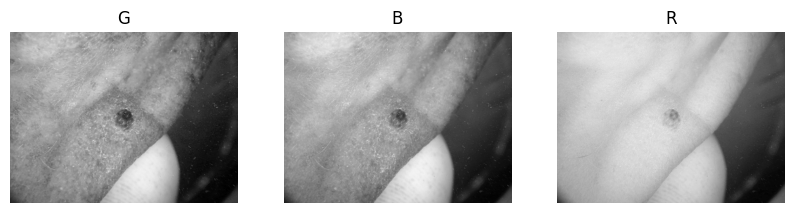

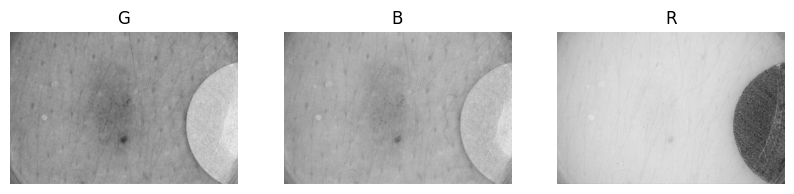

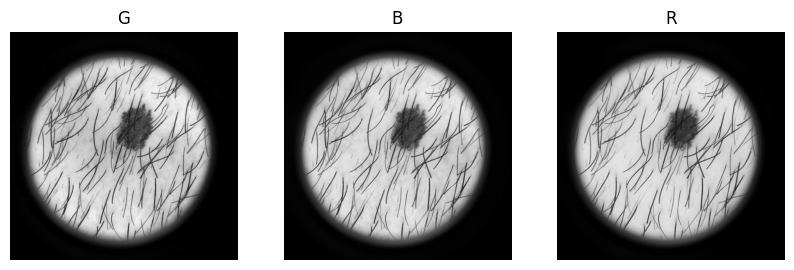

In [6]:
for i in range(12):
    image = get_image(img_list_num[i], path)
    f,axes = plt.subplots(1, 3, figsize=(10,10))
    channels = ['G', 'B', 'R']
    for i, ax in enumerate(axes.flat):
        ax.imshow(image[:,:,i], cmap='gray'), ax.axis('off'), ax.set_title(channels[i])

100%|██████████| 12/12 [00:02<00:00,  4.68it/s]


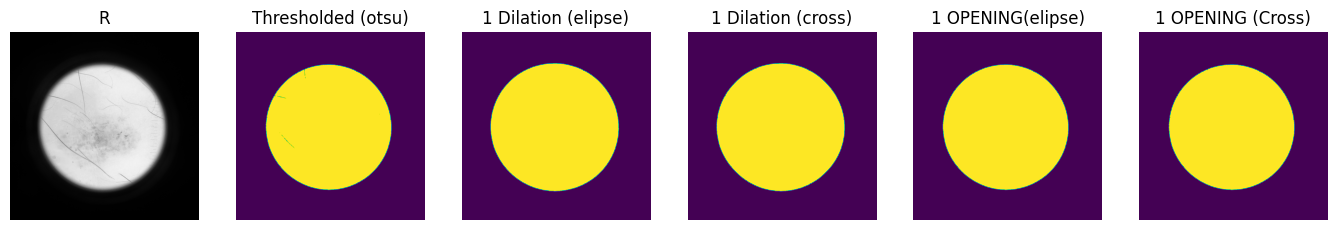

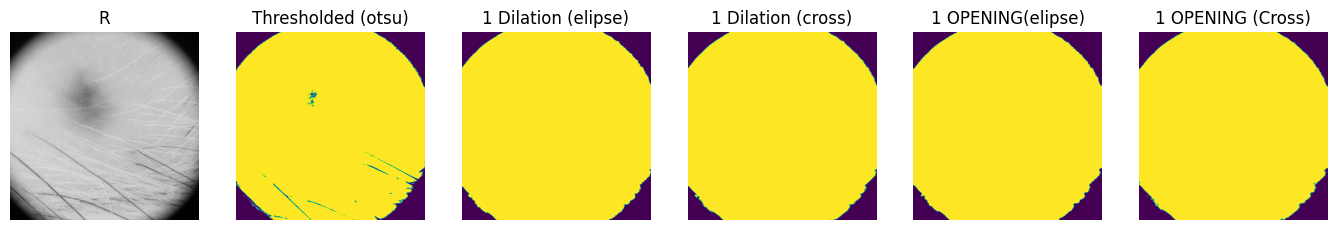

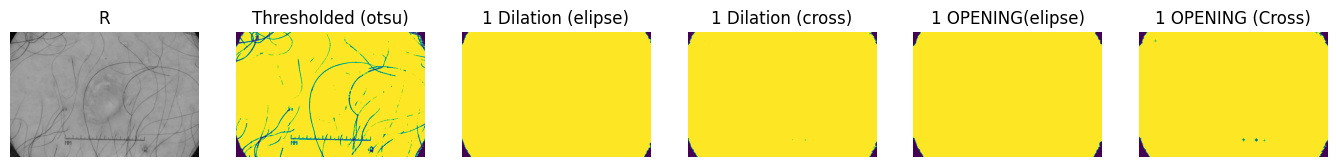

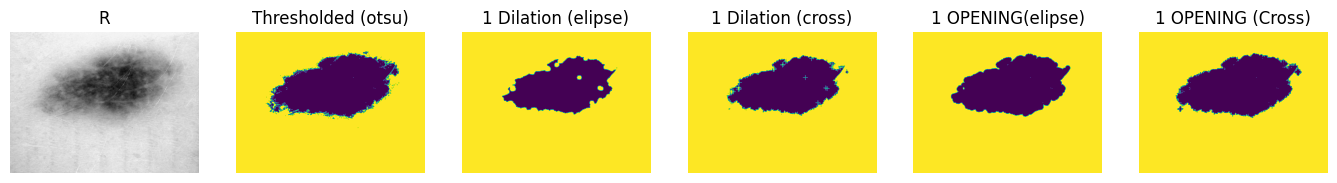

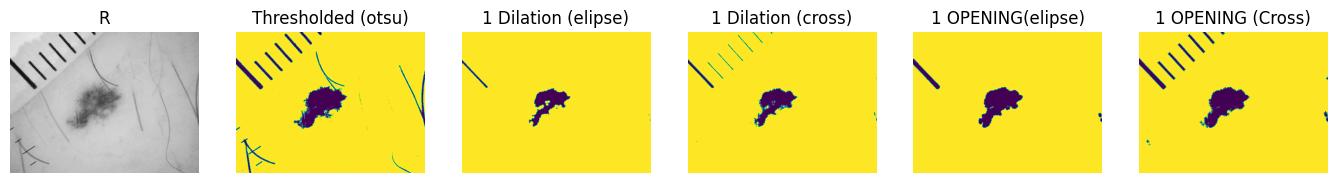

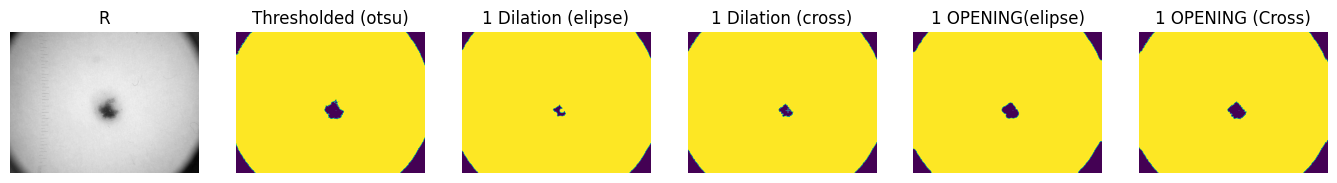

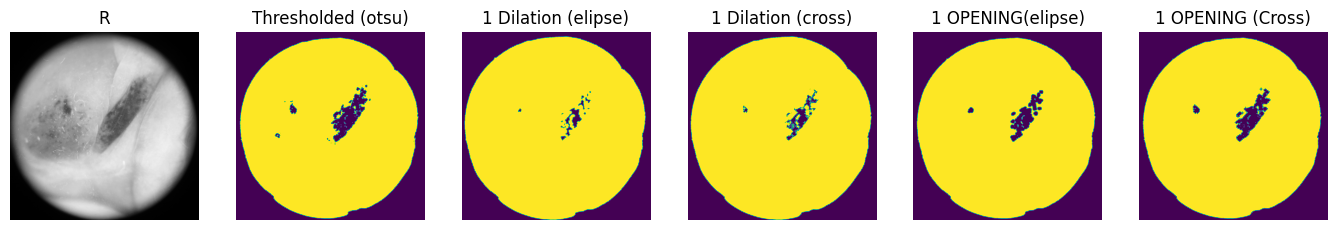

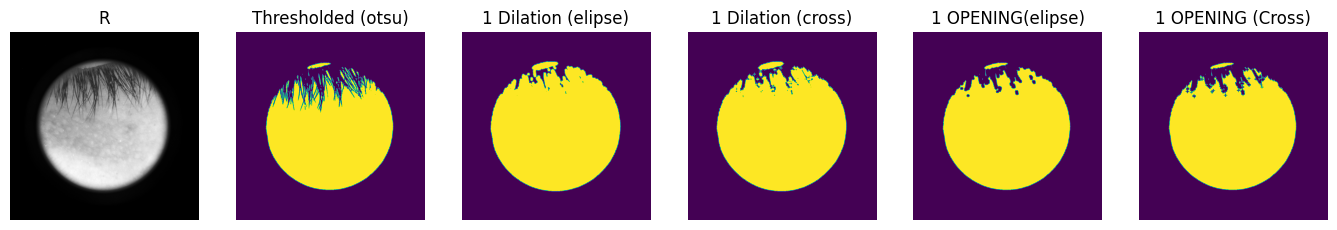

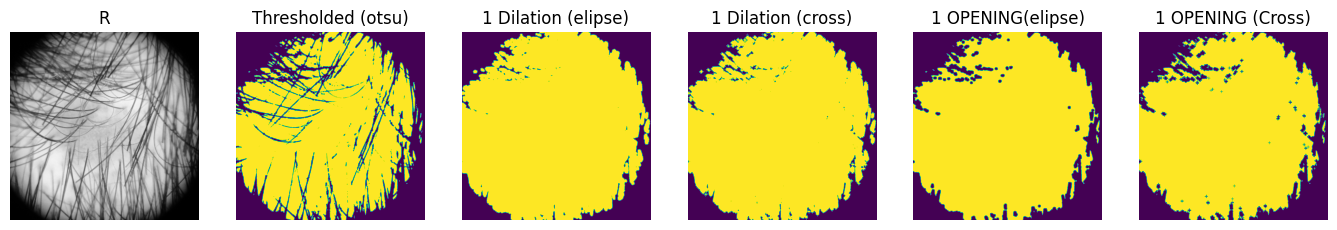

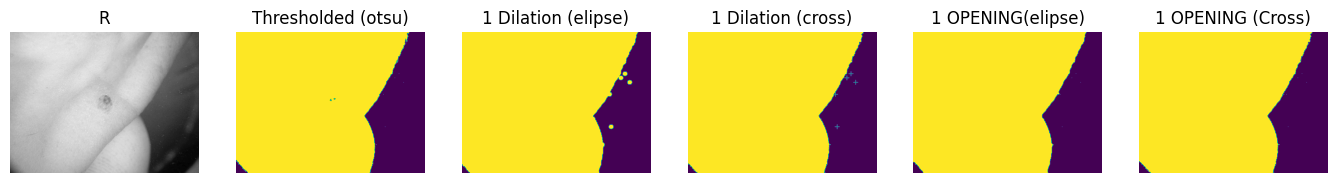

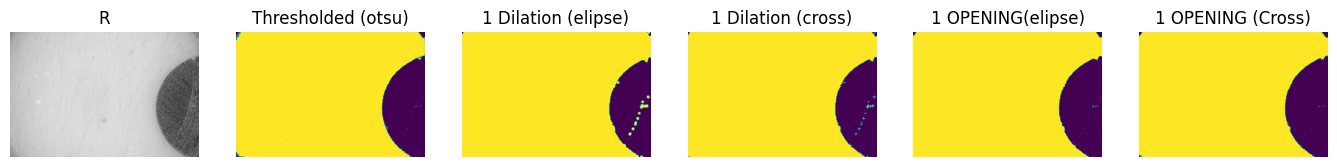

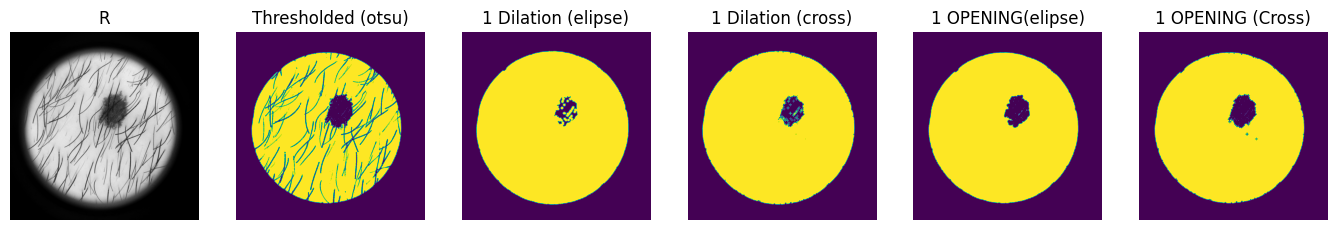

In [17]:
# Testing otsu and postprocessing with GCM
ee_size = 15

for i in tqdm(range(12)):
    image = get_image(img_list_num[i], path)
    f,axes = plt.subplots(1, 6, figsize=(17,10))
    axes[0].imshow(image[:,:,2], cmap='gray'), axes[0].axis('off'), axes[0].set_title('R')
    _, image_thres  = cv2.threshold(image[:,:,2], 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    axes[1].imshow(image_thres), axes[1].axis('off'), axes[1].set_title('Thresholded (otsu)')

    e_element = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (ee_size, ee_size))
    ee_cross = cv2.getStructuringElement(cv2.MORPH_CROSS, (ee_size, ee_size))
    axes[2].imshow(cv2.dilate(image_thres, e_element)), axes[2].axis('off'), axes[2].set_title('1 Dilation (elipse)')
    axes[3].imshow(cv2.dilate(image_thres, ee_cross)), axes[3].axis('off'), axes[3].set_title('1 Dilation (cross)')
    axes[4].imshow(cv2.morphologyEx(image_thres, cv2.MORPH_CLOSE, e_element)), axes[4].axis('off'), axes[4].set_title('1 OPENING(elipse)')
    axes[5].imshow(cv2.morphologyEx(image_thres, cv2.MORPH_CLOSE, ee_cross)), axes[5].axis('off'), axes[5].set_title('1 OPENING (Cross)')
# tsu_threshold, image_result = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

100%|██████████| 12/12 [00:03<00:00,  3.11it/s]


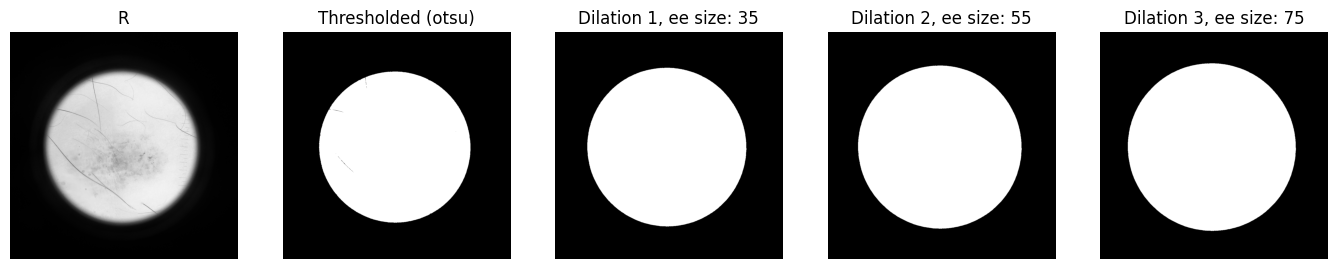

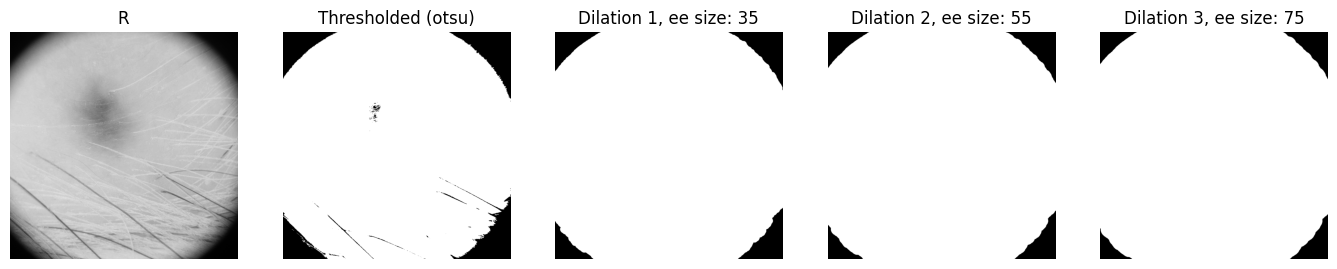

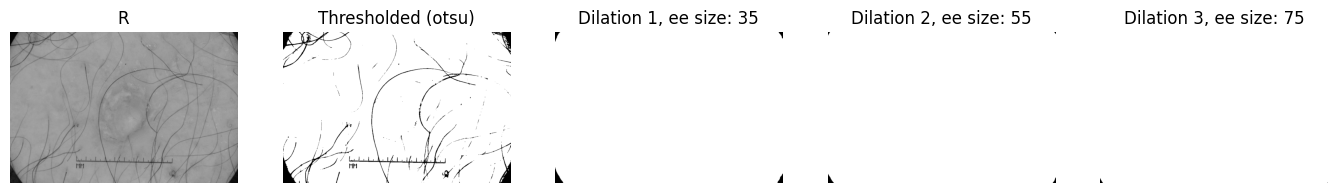

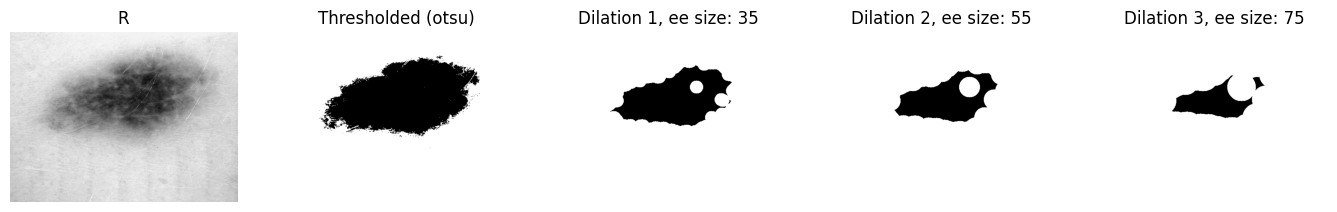

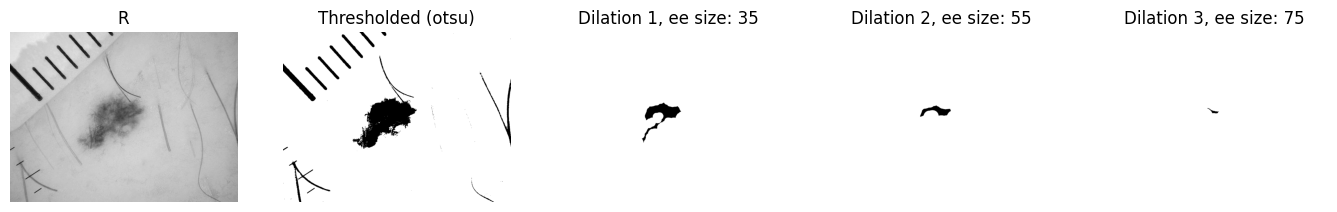

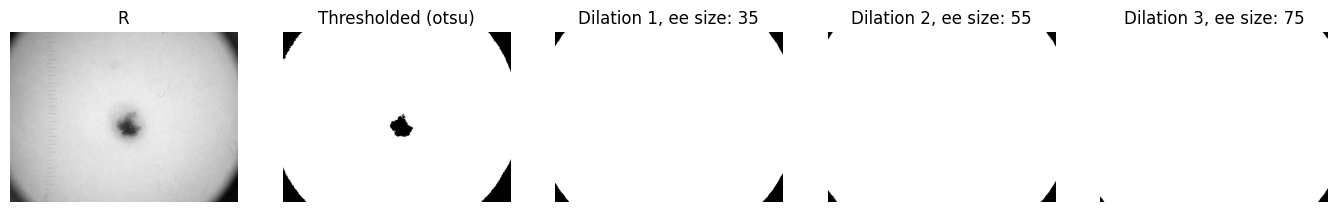

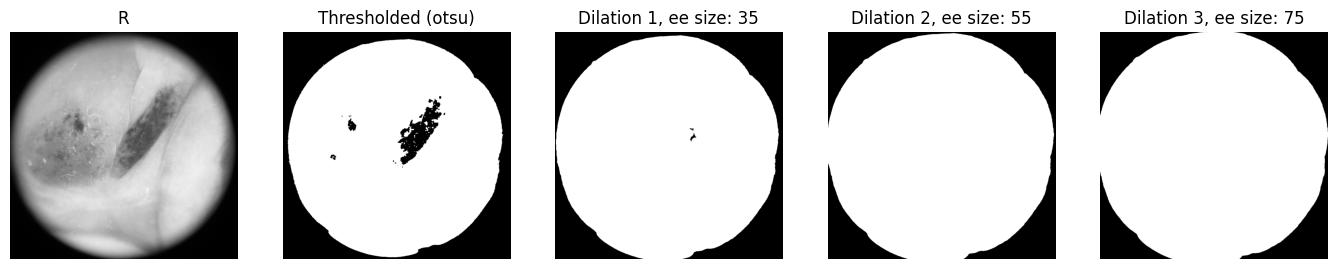

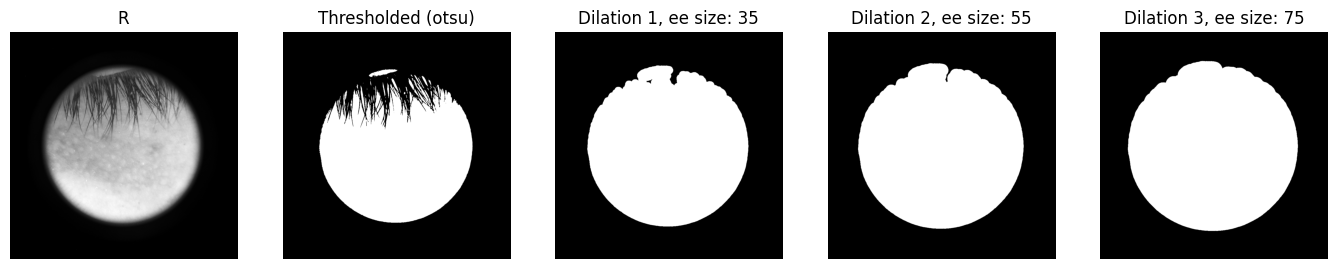

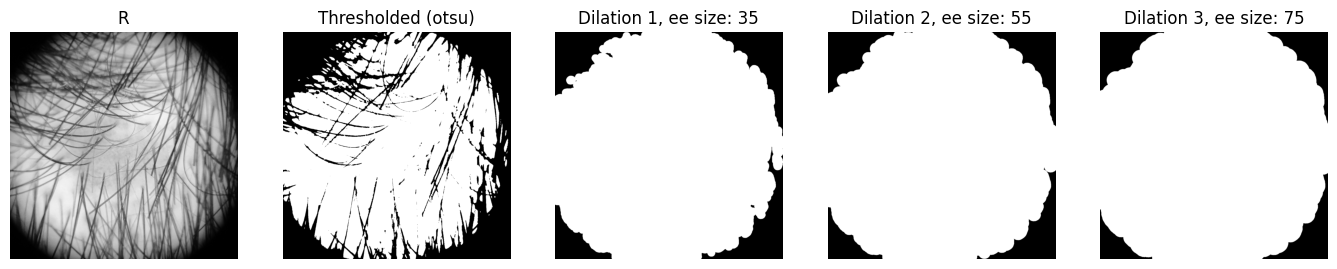

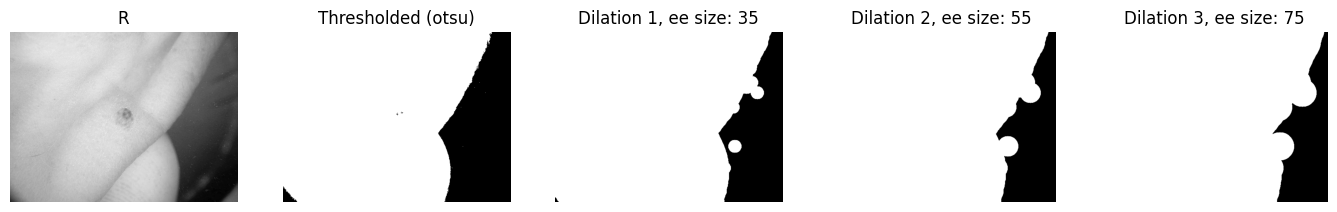

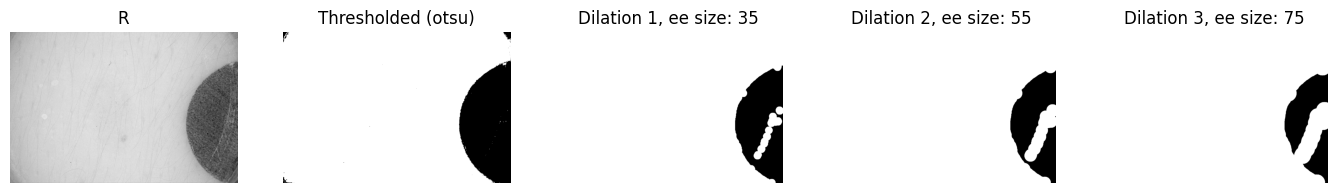

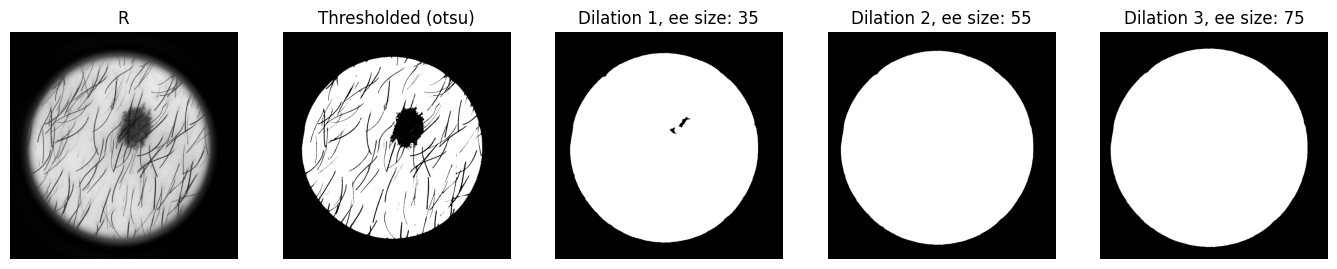

In [27]:
# otsu and consecutive dilations


for j in tqdm(range(12)):
    image = get_image(img_list_num[j], path)
    f,axes = plt.subplots(1, 5, figsize=(17,10))
    _, image_thres  = cv2.threshold(image[:,:,2], 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    axes[0].imshow(image[:,:,2], cmap='gray'), axes[0].axis('off'), axes[0].set_title('R')
    axes[1].imshow(image_thres, cmap='gray'), axes[1].axis('off'), axes[1].set_title('Thresholded (otsu)')
    for i in range(1,4):
        e_element = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (ee_size+10*i, ee_size+10*i))
        img_dilated = cv2.dilate(image_thres, e_element)
        axes[i+1].imshow(img_dilated, cmap='gray'), axes[i+1].axis('off'), axes[i+1].set_title(f'Dilation {i}, ee size: {ee_size+20*i}')

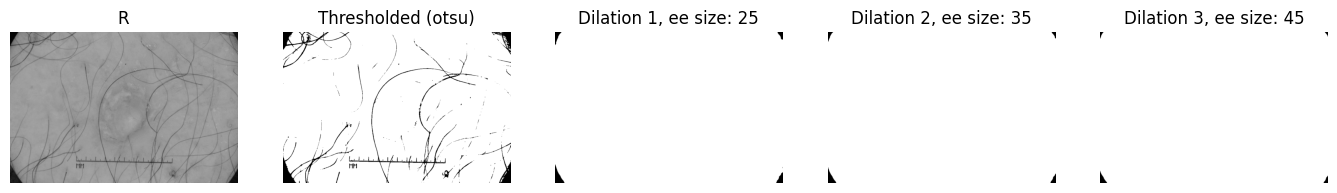

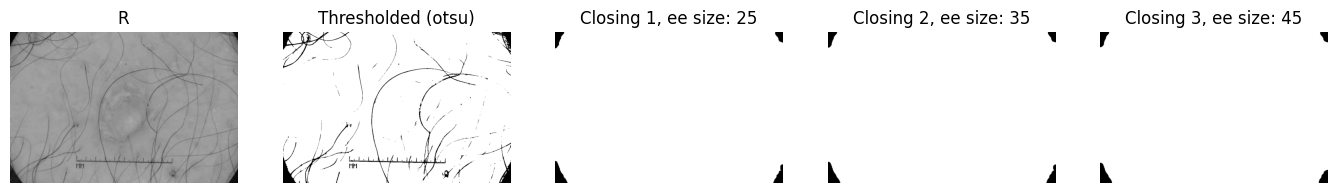

In [10]:
ee_size = 15

img_path, image = get_image(img_list_num[2], path)
f,axes = plt.subplots(1, 5, figsize=(17,10))
_, image_thres  = cv2.threshold(image[:,:,2], 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
axes[0].imshow(image[:,:,2], cmap='gray'), axes[0].axis('off'), axes[0].set_title('R')
axes[1].imshow(image_thres, cmap='gray'), axes[1].axis('off'), axes[1].set_title('Thresholded (otsu)')
for i in range(1,4):
    e_element = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (ee_size+10*i, ee_size+10*i))
    img_dilated = cv2.dilate(image_thres, e_element)
    axes[i+1].imshow(img_dilated, cmap='gray'), axes[i+1].axis('off'), axes[i+1].set_title(f'Dilation {i}, ee size: {ee_size+10*i}')


f,axes = plt.subplots(1, 5, figsize=(17,10))
axes[0].imshow(image[:,:,2], cmap='gray'), axes[0].axis('off'), axes[0].set_title('R')
axes[1].imshow(image_thres, cmap='gray'), axes[1].axis('off'), axes[1].set_title('Thresholded (otsu)')
for i in range(1,4):
    e_element = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (ee_size+5*i, ee_size+5*i))
    img_dilated = cv2.morphologyEx(image_thres, cv2.MORPH_CLOSE, e_element)
    axes[i+1].imshow(img_dilated, cmap='gray'), axes[i+1].axis('off'), axes[i+1].set_title(f'Closing {i}, ee size: {ee_size+10*i}')

### Hair removal before border removal

In [12]:
img_wo_hair = hair_removal([img_path])
print(img_path, img_wo_hair.shape)

../data/binary/train/nevus//nev00009.jpg (680, 1024, 3)


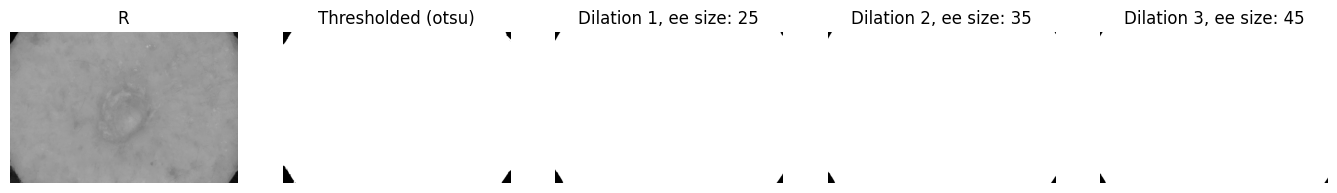

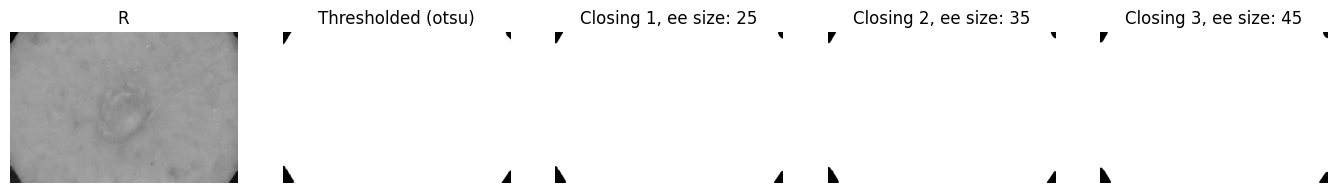

In [13]:
ee_size = 15

f,axes = plt.subplots(1, 5, figsize=(17,10))
_, image_thres  = cv2.threshold(img_wo_hair[:,:,2], 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
axes[0].imshow(img_wo_hair[:,:,2], cmap='gray'), axes[0].axis('off'), axes[0].set_title('R')
axes[1].imshow(image_thres, cmap='gray'), axes[1].axis('off'), axes[1].set_title('Thresholded (otsu)')
for i in range(1,4):
    e_element = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (ee_size+10*i, ee_size+10*i))
    img_dilated = cv2.dilate(image_thres, e_element)
    axes[i+1].imshow(img_dilated, cmap='gray'), axes[i+1].axis('off'), axes[i+1].set_title(f'Dilation {i}, ee size: {ee_size+10*i}')


f,axes = plt.subplots(1, 5, figsize=(17,10))
axes[0].imshow(img_wo_hair[:,:,2], cmap='gray'), axes[0].axis('off'), axes[0].set_title('R')
axes[1].imshow(image_thres, cmap='gray'), axes[1].axis('off'), axes[1].set_title('Thresholded (otsu)')
for i in range(1,4):
    e_element = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (ee_size+5*i, ee_size+5*i))
    img_dilated = cv2.morphologyEx(image_thres, cv2.MORPH_CLOSE, e_element)
    axes[i+1].imshow(img_dilated, cmap='gray'), axes[i+1].axis('off'), axes[i+1].set_title(f'Closing {i}, ee size: {ee_size+10*i}')

### Cropp image instead of getting mask

In [32]:
_, image = get_image(img_list_num[j], path)
print(image.shape)
image_cropped, y1, y2, x1, x2 = crop_img(image)
print(image_cropped.shape,y1, y2, x1, x2)

(1024, 1024, 3)
(642, 504, 3) 237 879 316 820


  0%|          | 0/12 [00:00<?, ?it/s]


ValueError: zero-size array to reduction operation minimum which has no identity

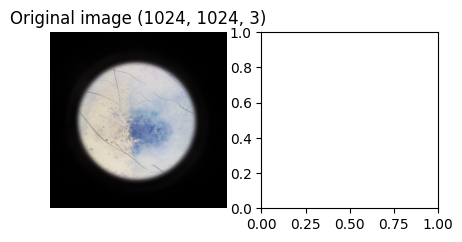

In [38]:
for j in tqdm(range(12)):
    _, image = get_image(img_list_num[j], path)
    f,axes = plt.subplots(1, 2, figsize=(5, 5))
    axes[0].imshow(image), axes[0].axis('off'), axes[0].set_title(f'Original image {image.shape}')
    image_cropped, y1, y2, x1, x2 = crop_img(image)
    axes[1].imshow(image_cropped), axes[1].axis('off'), axes[1].set_title(f'Cropped image {image_cropped.shape}')